In [346]:
import pandas as pd
from pandas import Series
from pandas import read_csv
from pandas import concat
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
import numpy 
%matplotlib inline

In [347]:
df = read_csv('well_5_clean.csv')
series = Series(data = df['Oil Volume'])

In [348]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [349]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [350]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [351]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [352]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [353]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [354]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [355]:
def fit_lstm(train, test, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    Val_X = test[:, 0]
    Val_X = Val_X.reshape((len(Val_X), 1, 1))
    Val_Y = test[:, 1]
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,return_sequences=False ))
    #second layer - make sure return_sequences=True to run this layer
    #model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    history = model.fit(X, y, epochs=nb_epoch, validation_data = (Val_X, Val_Y), shuffle = False, batch_size=batch_size)
    return model, history

In [356]:
#Get a dataset of differenced values to make stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [357]:
#returns a dataset with the differenced dataset and a differenced dataset with a lag of 1
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [358]:
#split train and test data
split_fraction = .67
train_size = int(len(supervised_values) * split_fraction)
test_size = len(supervised_values) - train_size
train, test = supervised_values[0 : train_size,:], supervised_values[train_size:len(supervised_values),:]

In [359]:
#Scales the train and the test data
scaler, train_scaled, test_scaled = scale(train, test)

In [360]:
#split train and test for the history parameter
Val_X = test_scaled[:, 0]
Val_X = Val_X.reshape((len(Val_X), 1, 1))
Val_Y = test_scaled[:, 1]

trainX = train_scaled[:, 0]
trainX = trainX.reshape((len(trainX), 1, 1))
trainY = train_scaled[:, 1]


In [361]:
lstm_model, history = fit_lstm(train_scaled, test_scaled, 1, 100, 4)

Train on 143 samples, validate on 71 samples
Epoch 1/100
143/143 [==============================] - 2s 17ms/step - loss: 0.0321 - val_loss: 0.0152
Epoch 2/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0331 - val_loss: 0.0156
Epoch 3/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0327 - val_loss: 0.0154
Epoch 4/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0325 - val_loss: 0.0154
Epoch 5/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0325 - val_loss: 0.0154
Epoch 6/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0324 - val_loss: 0.0154
Epoch 7/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0324 - val_loss: 0.0154
Epoch 8/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0324 - val_loss: 0.0154
Epoch 9/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0324 - val_loss: 0.0154
Epoch 10/100
143/143 [=======================

143/143 [==============================] - 1s 5ms/step - loss: 0.0321 - val_loss: 0.0155
Epoch 81/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0321 - val_loss: 0.0155
Epoch 82/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0321 - val_loss: 0.0155
Epoch 83/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0321 - val_loss: 0.0155
Epoch 84/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0321 - val_loss: 0.0155
Epoch 85/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0321 - val_loss: 0.0155
Epoch 86/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0321 - val_loss: 0.0155
Epoch 87/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0321 - val_loss: 0.0155
Epoch 88/100
143/143 [==============================] - 1s 6ms/step - loss: 0.0321 - val_loss: 0.0155
Epoch 89/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0321 - val_loss: 

In [362]:
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]

In [363]:
train_predictions = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, -i)
    # store forecast
    train_predictions.append(yhat)

In [364]:
rmse = sqrt(mean_squared_error(raw_values[train_size + 1:], predictions))
print('Test RMSE: %.3f' % rmse)

train_rmse = sqrt(mean_squared_error(raw_values[:train_size ], train_predictions))
print('Train RMSE: %.3f' % train_rmse)

Test RMSE: 12.024
Train RMSE: 3.007


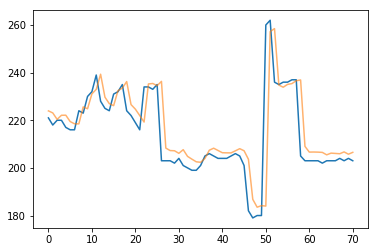

In [365]:
plt.plot(raw_values[train_size + 1:])
plt.plot(predictions, alpha = .6)


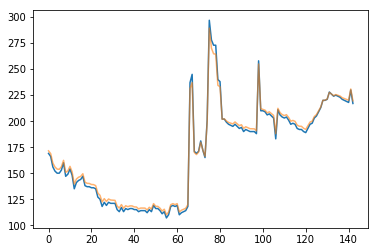

In [366]:
plt.plot(raw_values[:train_size ])
plt.plot(train_predictions, alpha = .6)


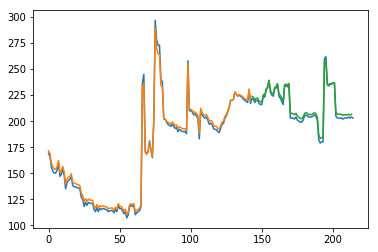

In [367]:
plt.plot(raw_values)
plt.plot(train_predictions)
plt.plot([None for x in train_predictions] + [x for x in predictions])

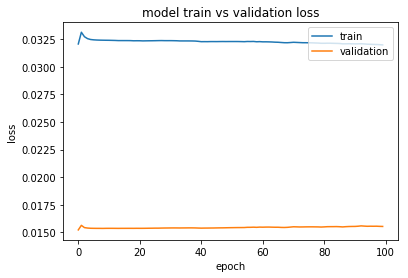

In [368]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')